In [1]:
'''
%%writefile ns.py
start = time.time()
end = time.time()
print(end-start)
'''
import tensorflow as tf
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os as os
import sys
from pathlib import Path
import sklearn as sk 
import time
import scipy.stats as stats
from sklearn.preprocessing.data import QuantileTransformer
from tensorflow.keras import regularizers

mhsdir = Path(os.getcwd()).parent
sys.path.append(os.path.join(mhsdir, 'src'))

import ns

datarawdir = os.path.join(mhsdir, 'data\\raw\\YC')
dataprepdir = os.path.join(mhsdir, 'data\\preprocessed')
dataprepnsdir = os.path.join(mhsdir, 'data\\preprocessed\\ns')
modeldir = os.path.join(mhsdir, 'models')

tempdatarawdir = os.path.join(mhsdir, 'temp\\data\\raw\\YC')
tempdataprepdir = os.path.join(mhsdir, 'temp\\data\\preprocessed')
tempdataprepnsdir = os.path.join(mhsdir, 'temp\\data\\preprocessed\\ns')

tfk = tf.keras
tfkl = tf.keras.layers

train_csv = os.path.join(traindir, 'train_real_0_0_410_38_40938.txt')
test_csv = os.path.join(traindir, 'train_real_410_0_9132.txt')

In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\

# Final preprocessing

In [39]:
df = None
traindir = os.path.join(mhsdir, 'data\\train\\repository\\train')
testdir = os.path.join(mhsdir, 'data\\train\\repository\\test')

for filename in os.listdir(traindir):
    path=os.path.join(traindir, filename)
    df1 = pd.read_csv(path, sep = ';', header = None)
    if df is None:
        df = df1
        continue
    df = pd.concat([df, df1])
train_df = df.iloc[:,:-1]
test_df = pd.read_csv(os.path.join(testdir, "train_real.txt"), sep = ';', header = None).iloc[:,:-1]

lx = (test_df.iloc[:,-14:-2] < -0.00001).any(axis = 1)
test_df = test_df[~lx]
print(lx.sum())
lx = (train_df.iloc[:,-14:-2] < -0.00001).any(axis = 1)
train_df = train_df[~lx]
print(lx.sum())

for i in range(100):
    train_df = train_df.sample(frac = 1).reset_index(drop=True)
    
repodir = os.path.join(mhsdir, 'data\\train\\repository')

trainfilepath = os.path.join(traindir, 'train_{}'.format(train_df.shape[0]) )
train_df.to_csv(trainfilepath,index = False)

testfilepath = os.path.join(traindir, 'test_{}'.format(test_df.shape[0]) )
test_df.to_csv(testfilepath,index = False)

1
10958


# Train and build model

In [40]:
def to_category(freqv): 
    res = np.zeros((freqv.shape[0],12))
    for i in range(freqv.shape[0]):
        if freqv[i] == 1:
            res[i] = np.array([1,1,1,1,1,1,1,1,1,1,1,1],dtype = 'float')
        elif freqv[i] == 2:
            res[i] = np.array([0,1,0,1,0,1,0,1,0,1,0,1],dtype = 'float') 
        elif freqv[i] == 3:
            res[i] = np.array([0,0,1,0,0,1,0,0,1,0,0,1],dtype = 'float')
        elif freqv[i] == 4:
            res[i] = np.array([0,0,0,1,0,0,0,1,0,0,0,1],dtype = 'float')
        elif freqv[i] == 6:
            res[i] = np.array([0,0,0,0,0,1,0,0,0,0,0,1],dtype = 'float')
        elif freqv[i] == 12:
            res[i] = np.array([0,0,0,0,0,0,0,0,0,0,0,1],dtype = 'float')
    return res

def convertor(df):
    df.columns = ['n','id','bmode','tb1','tb2','tb3','tb4','tb5','tb6','tb7','tb8','tb9','tb10','tb11','tb12','tb13','tb14','tb15','tb16','tb17','tb18','tb19','tb20','tb21',
           'ts1','ts2','ts3','ts4','ts5','ts6','ts7','ts8','ts9','ts10','ts11','ts12','ts13','ts14','ts15','ts16','ts17','ts18','ts19','ts20','ts21',
           't1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11','t12','t13','t14','t15','t16','t17','t18','t19','t20','t21',
           'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','smode','freq']
    act_columns = ['tb1','tb2','tb3','tb4','tb5','tb6','tb7','tb8','tb9','tb10','tb11','tb12','tb13','tb14','tb15','tb16','tb17','tb18','tb19','tb20','tb21',
               'ts1','ts2','ts3','ts4','ts5','ts6','ts7','ts8','ts9','ts10','ts11','ts12','ts13','ts14','ts15','ts16','ts17','ts18','ts19','ts20','ts21',
               'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12']
    coup_columns = ['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12'] 
    target = df[coup_columns].sum(axis=1)
    data = df[act_columns].copy()
    data.loc[:,coup_columns] = to_category(df['freq'])
    return data,target

def VaR(ar):
    sar = np.sort(ar)
    sz = sar.shape[0]
    rsk = np.rint(sz * (1 - np.array([0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.9]))).astype('int')
    return sar[rsk]

In [44]:
train_df = pd.read_csv(trainfilepath)
test_df = pd.read_csv(testfilepath)
train_data, train_target = convertor(train_df)
test_data, test_target = convertor(test_df)

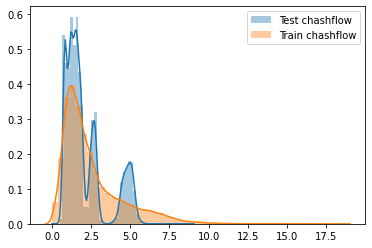

In [47]:
sn.distplot(test_target,label = 'Test chashflow')
sn.distplot(train_target,label = 'Train chashflow')
plt.legend()

In [48]:
model = tf.keras.Sequential([
                    tf.keras.layers.Dense(64, activation='relu',input_shape = [len(train_data.keys())]),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1(0.0001)),
                    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    #tf.keras.layers.Dense(64, activation='relu'),
                    #tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.00001)),                 
                    #tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.0001)),
                    tf.keras.layers.Dense(1)       
])
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.Adagrad(0.001),
              metrics = ['mae','mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3520      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6

In [51]:
EPOCHS = 20
history = model.fit(
  train_data, train_target,
  batch_size = 64,
  epochs=EPOCHS, validation_data=(test_data,test_target))

Epoch 1/20
2485/2485 [==============================] - 5s 2ms/step - loss: 0.1695 - mae: 0.0761 - mse: 0.0145 - val_loss: 0.1664 - val_mae: 0.0863 - val_mse: 0.0116
Epoch 2/20
2485/2485 [==============================] - 5s 2ms/step - loss: 0.1688 - mae: 0.0754 - mse: 0.0143 - val_loss: 0.1658 - val_mae: 0.0858 - val_mse: 0.0115
Epoch 3/20
2485/2485 [==============================] - 5s 2ms/step - loss: 0.1681 - mae: 0.0748 - mse: 0.0141 - val_loss: 0.1646 - val_mae: 0.0839 - val_mse: 0.0109
Epoch 4/20
2485/2485 [==============================] - 5s 2ms/step - loss: 0.1673 - mae: 0.0743 - mse: 0.0139 - val_loss: 0.1644 - val_mae: 0.0846 - val_mse: 0.0111
Epoch 5/20
2485/2485 [==============================] - 5s 2ms/step - loss: 0.1666 - mae: 0.0738 - mse: 0.0136 - val_loss: 0.1638 - val_mae: 0.0842 - val_mse: 0.0111
Epoch 6/20
2485/2485 [==============================] - 5s 2ms/step - loss: 0.1659 - mae: 0.0733 - mse: 0.0135 - val_loss: 0.1634 - val_mae: 0.0844 - val_mse: 0.0111
Epoc

In [52]:
y_act = test_target.to_numpy()
y_pred = model.predict(test_data).reshape(-1)

In [53]:
VaR(y_act)

array([0.70956305, 0.7385341 , 0.7572623 , 0.77093983, 0.78284324,
       0.79401   , 0.80425612, 0.81390585, 0.82398719, 0.83388334])

In [54]:
VaR(y_pred)

array([0.5785115 , 0.6261922 , 0.66098017, 0.6924633 , 0.7204937 ,
       0.74642247, 0.771259  , 0.7940546 , 0.81683236, 0.84127957],
      dtype=float32)

In [55]:
dff = pd.DataFrame({'Act': test_target, 'Pred' : y_pred})
dff.describe()

,Act,Pred
count,102229.000000,102229.000000
mean,2.119526,2.093279
std,1.353206,1.342620
min,0.322815,0.101528
25%,1.168864,1.157181
50%,1.603277,1.615367
75%,2.647212,2.577241
max,8.725821,7.805378


<AxesSubplot:>

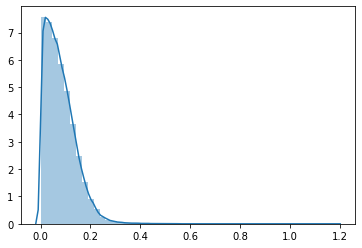

In [56]:
sn.distplot(np.abs(y_act-y_pred))

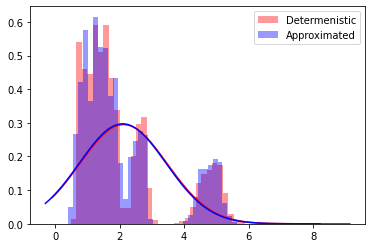

In [57]:
sn.distplot(y_act,fit = stats.norm, color = 'red', label = 'Determenistic',fit_kws={"color":"red"},kde = False)
sn.distplot(y_pred, fit = stats.norm, color = 'blue', label = 'Approximated',fit_kws={"color":"blue"},kde=False)
plt.legend()

In [58]:
version = 1
export_path = os.path.join(modeldir, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')

export_path = C:\Users\PLDD\Practice\GitHub\Python\MHS\models\1

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\PLDD\Practice\GitHub\Python\MHS\models\1\assets

Saved model:
